In [47]:
import math
import pandas as pd
import numpy as np
from urllib.parse import urlparse
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")

In [48]:
# File paths (edit if needed)
# -----------------------------
AUTHORS_CSV = '/content/updated_dataset.csv'
REPOSTS_CSV = '/content/viral_reposts_full_enriched.csv'
MBFC_CSV = '/content/media-bias-fc-scrape.csv'

OUT_PLOT_REL = 'network_reliability_top300.png'
OUT_PLOT_LEAN = 'network_leaning_top300.png'
OUT_NODES_CSV = 'nodes_top300.csv'
OUT_EDGES_CSV = 'edges_top300.csv'
OUT_RANK_CSV = 'rank_top300_full.csv'

In [49]:
def safe_print(msg):
    print(msg, flush=True)


# -----------------------------
# Utilities

def normalize_domain(url):
    """Normalize a URL/host to its base domain."""
    if pd.isna(url) or not isinstance(url, str) or url.strip() == '':
        return None
    try:
        parsed = urlparse(url)
        domain = parsed.netloc.lower().strip() or url.lower().strip()
        for prefix in ['www.', 'm.', 'amp.']:
            if domain.startswith(prefix):
                domain = domain[len(prefix):]
        domain = domain.split(':')[0]
        domain = domain.split('/')[0]
        return domain if domain else None
    except Exception:
        return (
            url.lower()
               .replace('https://', '')
               .replace('http://', '')
               .replace('www.', '')
               .split('/')[0]
        )


def map_reliability_label(raw):
    if pd.isna(raw):
        return 'unknown'
    s = str(raw).strip().upper()
    if 'HIGH' in s:
        return 'reliable'
    if s == '' or s == 'NAN':
        return 'unknown'
    return 'questionable'


def map_leaning_label(raw):
    if pd.isna(raw):
        return 'unknown'
    s = str(raw).lower()
    if s.startswith('left'):
        return 'left'
    if s.startswith('right'):
        return 'right'
    if 'center' in s or 'least' in s:
        return 'center'
    return 'unknown'

In [50]:
# Load datasets

safe_print("Loading CSVs...")
authors_df = pd.read_csv(AUTHORS_CSV)
reposts_df = pd.read_csv(REPOSTS_CSV)
mbfc_df = pd.read_csv(MBFC_CSV)
safe_print(f"Loaded authors: {len(authors_df)} rows, reposts: {len(reposts_df)} rows, mbfc: {len(mbfc_df)} rows")

Loading CSVs...
Loaded authors: 100747 rows, reposts: 138574 rows, mbfc: 1604 rows


In [51]:
# Total number of posts with and without URLs and Extract & normalize domains from authors_df external_url
# -----------------------------
safe_print("\n2) Extracting domains from authors CSV (external_url)...")
if 'external_url' not in authors_df.columns:
    safe_print("   WARNING: 'external_url' not found in authors CSV. Available columns: " + ", ".join(authors_df.columns))
authors_df['external_domain'] = authors_df.get('external_url', pd.Series([None]*len(authors_df))).map(normalize_domain)
cnt_with = authors_df['external_url'].notna().sum()
cnt_without = authors_df['external_url'].isna().sum()
safe_print(f"   Posts with external URL: {cnt_with}")
safe_print(f"   Posts without external URL: {cnt_without}")



2) Extracting domains from authors CSV (external_url)...
   Posts with external URL: 20165
   Posts without external URL: 80582


In [52]:
# Prepare MBFC mapping

safe_print("Preparing MBFC domain -> reliability/leaning mapping...")

domain_col = None
for c in mbfc_df.columns:
    if any(k in c.lower() for k in ["url", "website", "domain"]):
        domain_col = c
        break
if domain_col is None:
    for c in mbfc_df.columns:
        if c.lower() in ["site_name", "name", "source"]:
            domain_col = c
            break
if domain_col is None:
    raise RuntimeError("Could not detect domain column in MBFC CSV.")

safe_print(f"Using MBFC column '{domain_col}' for domain identification.")


def normalize_domain_safely(x):
    if pd.isna(x) or str(x).strip() == '':
        return None
    x = str(x).strip().lower()
    try:
        parsed = urlparse(x)
        domain = parsed.netloc or x
        for prefix in ['www.', 'm.', 'amp.']:
            if domain.startswith(prefix):
                domain = domain[len(prefix):]
        domain = domain.split(':')[0].split('/')[0]
        return domain
    except:
        return (
            x.replace("www.", "")
             .replace("http://", "")
             .replace("https://", "")
             .split('/')[0]
        )


mbfc_df['domain_norm'] = mbfc_df[domain_col].astype(str).map(normalize_domain_safely)
mbfc_df = mbfc_df[mbfc_df['domain_norm'].notna() & (mbfc_df['domain_norm'].str.len() > 0)]


# detect MBFC reliability & leaning columns
reliability_col = next((c for c in mbfc_df.columns if any(k in c.lower() for k in ["factual", "reliab", "fact"])), None)
leaning_col = next((c for c in mbfc_df.columns if any(k in c.lower() for k in ["bias", "lean"])), None)

if reliability_col is None:
    safe_print("WARNING: No reliability column detected.")
if leaning_col is None:
    safe_print("WARNING: No leaning column detected.")

mbfc_df["reliability_raw"] = mbfc_df[reliability_col] if reliability_col else None
mbfc_df["leaning_raw"] = mbfc_df[leaning_col] if leaning_col else None

mbfc_df["reliability"] = mbfc_df["reliability_raw"].map(map_reliability_label)
mbfc_df["leaning"] = mbfc_df["leaning_raw"].map(map_leaning_label)

author_bias_map = (
    mbfc_df.drop_duplicates("domain_norm")
           .set_index("domain_norm")[["reliability", "leaning"]]
           .to_dict("index")
)

safe_print(f"MBFC domains indexed: {len(author_bias_map)}")

Preparing MBFC domain -> reliability/leaning mapping...
Using MBFC column 'url' for domain identification.
MBFC domains indexed: 1591


In [53]:
# Attach MBFC metadata to authors

safe_print("Attaching MBFC metadata to authors...")

def get_meta_for_domain(d):
    return (
        author_bias_map.get(d, {'reliability': 'unknown', 'leaning': 'unknown'})['reliability'],
        author_bias_map.get(d, {'reliability': 'unknown', 'leaning': 'unknown'})['leaning']
    )


authors_df['reliability'], authors_df['leaning'] = zip(*authors_df['external_domain'].map(get_meta_for_domain))
authors_df['reliability'] = authors_df['reliability'].astype(str).str.lower()
authors_df['leaning'] = authors_df['leaning'].astype(str).str.lower()

safe_print(f"Sample reliability counts: {authors_df['reliability'].value_counts().to_dict()}")


Attaching MBFC metadata to authors...
Sample reliability counts: {'unknown': 99309, 'reliable': 1093, 'questionable': 345}


In [54]:
authors_df['reliability'], authors_df['leaning'] = zip(*authors_df['external_domain'].map(get_meta_for_domain))


In [55]:
# Count MBFC matching vs non-matching domains
safe_print("\nCalculating MBFC URL matching counts...")

authors_df["mbfc_match"] = authors_df["external_domain"].isin(author_bias_map.keys())

urls_matching = authors_df["mbfc_match"].sum()
urls_not_matching = (~authors_df["mbfc_match"]).sum()

safe_print(f"URLs matching MBFC: {urls_matching}")
safe_print(f"URLs NOT matching MBFC: {urls_not_matching}")



Calculating MBFC URL matching counts...
URLs matching MBFC: 1438
URLs NOT matching MBFC: 99309


In [56]:
authors_df

,post_uri,cid,text,author_did,author_handle,created_at,hashtags,mentions,external_url,like_count,reply_count,repost_count,quote_count,external_domain,reliability,leaning,mbfc_match
0,at://did:plc:5dsswcxlz2rv4ver3ucvphrf/app.bsky...,bafyreigixbrerlixwour3rnxatxygerxaiestlljjygh4...,God I wanna draw so much stuff but the depress...,did:plc:5dsswcxlz2rv4ver3ucvphrf,haunted-stardust.bsky.social,2025-11-21 10:18:16.106000+00:00,['#talkingashes'],[],NaN,0,0,0,0,None,unknown,unknown,False
1,at://did:plc:r6zs4zqvpds4mkgl6ci4oucp/app.bsky...,bafyreidbkonocddivkuoejsjrbfkmwctslexlcidddhiu...,Better Life Recovery provides compassionate me...,did:plc:r6zs4zqvpds4mkgl6ci4oucp,betterliferecovery.bsky.social,2025-11-21 10:16:58.306000+00:00,"['#MentalHealth', '#RecoveryJourney', '#NewJer...",[],NaN,0,0,0,0,None,unknown,unknown,False
2,at://did:plc:ubheotjr2g2y2aebd3w7r6bk/app.bsky...,bafyreibd4hhaozysc4g5qztjgf6ytdccefbw3k4ngeika...,I hang out there because there's fascists to b...,did:plc:ubheotjr2g2y2aebd3w7r6bk,dantendigitalis.bsky.social,2025-11-21 10:10:00.733000+00:00,[],[],https://media.tenor.com/P2av7q8C0lIAAAAC/obeli...,0,0,0,0,media.tenor.com,unknown,unknown,False
3,at://did:plc:weu25d43k3b3xeuj2nhmgsr2/app.bsky...,bafyreiehtwwyar4cceli6bvmqygn6vpmu3kmu4qaj6cb6...,You mean you can't just...think depression awa...,did:plc:weu25d43k3b3xeuj2nhmgsr2,jaffne.bsky.social,2025-11-21 10:08:56.232000+00:00,[],[],NaN,2,2,0,0,None,unknown,unknown,False
4,at://did:plc:6dn5rtzoyn2on6ltmtmnk6gj/app.bsky...,bafyreia74iho7feiewzksdpafhvtuenjsblkg3z5a4khf...,Jag som alltid tänkt att han varit fast i en d...,did:plc:6dn5rtzoyn2on6ltmtmnk6gj,lillajonna.bsky.social,2025-11-21 10:08:08.295000+00:00,[],[],NaN,0,0,0,0,None,unknown,unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100742,at://did:plc:an3usnfooegevfkn7tm43sbi/app.bsky...,bafyreidniffyad5dumhztapxhnsloujfudhcxjnopj7qd...,🚨 Breaking News 🚨\n\nLady Gaga Opens Up About ...,did:plc:an3usnfooegevfkn7tm43sbi,southfloridamedia.bsky.social,2025-03-12 14:37:32.743000+00:00,"['#LadyGaga', '#MentalHealth', '#Healing', '#S...",[],https://sfl.media/lady-gaga-opens-up-about-her...,3,0,0,0,sfl.media,unknown,unknown,False
100743,at://did:plc:3fybw5s7anhglzotjie7fzjh/app.bsky...,bafyreifqtu6evt3pxn6ofa4d4jyy6z2afjmg5pldj46kv...,"Ig it's partially my own fault, my mom being o...",did:plc:3fybw5s7anhglzotjie7fzjh,vanillabrwnsugr.bsky.social,2025-03-12 14:24:54.265000+00:00,[],[],NaN,49,6,1,0,None,unknown,unknown,False
100744,at://did:plc:ytl3mjj4lekn53k5otba2vsv/app.bsky...,bafyreifwbuhoblnhek3wngch6owcfh4n65jzsus7dwnq3...,That dude I married the second time. He initia...,did:plc:ytl3mjj4lekn53k5otba2vsv,pagesandbeats.blacksky.app,2025-03-12 14:04:31.574000+00:00,[],[],NaN,1,0,0,0,None,unknown,unknown,False
100745,at://did:plc:cu3xsjrwqdsv37fcz2dlp2we/app.bsky...,bafyreidejyjl24w3jggw766ch642tujq6levy4f3xe7kd...,Earn up to 12 CEUs and up to 3 hours in Ethics...,did:plc:cu3xsjrwqdsv37fcz2dlp2we,nbhap.bsky.social,2025-03-12 14:00:39.330000+00:00,"['#Oklahoma', '#conference', '#addiction', '#c...",[],NaN,0,0,0,0,None,unknown,unknown,False


In [57]:
# Unique users who posted URLs matching MBFC
unique_users_matching = authors_df[authors_df["mbfc_match"]]['author_did'].nunique()
safe_print(f"Unique users posting MBFC-matched URLs: {unique_users_matching}")

Unique users posting MBFC-matched URLs: 1036


In [58]:
# Prepare CIDs and merge reposts

safe_print("Preparing CIDs and merging reposts...")
authors_df['post_cid'] = authors_df.get('post_uri', pd.Series([None]*len(authors_df))).astype(str).map(
    lambda x: x.split('/')[-1] if pd.notna(x) else None
)

reposts_df['post_cid'] = reposts_df.get('post_id', pd.Series([None]*len(reposts_df)))

if 'reposted_by_did' not in reposts_df.columns and 'reposted_by_handle' in reposts_df.columns:
    reposts_df = reposts_df.rename(columns={'reposted_by_handle': 'reposted_by_did'})

author_id_col = next((c for c in ['author_did', 'author_id', 'author'] if c in authors_df.columns), None)
if author_id_col is None:
    raise RuntimeError("Could not find an author_id column in authors CSV.")

authors_for_merge = (
    authors_df[['post_cid', author_id_col, 'reliability', 'leaning']]
    .rename(columns={author_id_col: 'author_did'})
)

merged = reposts_df.merge(authors_for_merge, on='post_cid', how='inner')
safe_print(f"Rows after merging reposts -> authors: {len(merged)}")

Preparing CIDs and merging reposts...
Rows after merging reposts -> authors: 138574


In [59]:
# Interaction matrix

safe_print("Building interaction matrix...")
interaction = merged.groupby(['reposted_by_did', 'author_did']).size().unstack(fill_value=0)
interaction = interaction.reindex(sorted(interaction.columns), axis=1)
authors = list(interaction.columns)
safe_print(f"Interaction matrix shape: {interaction.shape}")


Building interaction matrix...
Interaction matrix shape: (84048, 3831)


In [60]:
# Cosine similarity

safe_print("Computing cosine similarity...")
sim = pd.DataFrame(cosine_similarity(interaction.T), index=authors, columns=authors)
safe_print(f"Similarity matrix shape: {sim.shape}")

Computing cosine similarity...
Similarity matrix shape: (3831, 3831)


In [61]:
# Preliminary graph

safe_print("Building preliminary graph...")
tri_vals = sim.values[np.triu_indices_from(sim.values, k=1)]
median_initial = float(np.median(tri_vals))
if median_initial == 0:
    median_initial = (
        float(np.percentile(tri_vals[tri_vals > 0], 25))
        if np.any(tri_vals > 0) else 0.0
    )
safe_print(f"Adjusted initial median similarity: {median_initial:.6e}")

preG = nx.Graph()
meta_lookup = authors_df.drop_duplicates(author_id_col).set_index(author_id_col)[['reliability', 'leaning']].to_dict('index')

for a in authors:
    md = meta_lookup.get(a, {'reliability': 'unknown', 'leaning': 'unknown'})
    preG.add_node(a, reliability=md['reliability'], leaning=md['leaning'])

edge_add_count = 0
for i, a in enumerate(authors):
    for j in range(i+1, len(authors)):
        b = authors[j]
        w = float(sim.iloc[i, j])
        if w > median_initial and w > 0:
            preG.add_edge(a, b, weight=w)
            edge_add_count += 1

safe_print(f"Preliminary graph nodes: {preG.number_of_nodes()} edges: {preG.number_of_edges()}")

Building preliminary graph...
Adjusted initial median similarity: 8.470319e-03
Preliminary graph nodes: 3831 edges: 40519


In [62]:
# PageRank & weighted degree

safe_print("Computing PageRank & weighted degree...")
pagerank = nx.pagerank(preG, weight='weight')

weighted_deg = {
    n: sum(d.get('weight', 0) for _, _, d in preG.edges(n, data=True))
    for n in preG.nodes()
}

rank_df = pd.DataFrame({
    'author_did': list(preG.nodes()),
    'pagerank': [pagerank.get(n, 0.0) for n in preG.nodes()],
    'weighted_degree': [weighted_deg.get(n, 0.0) for n in preG.nodes()],
    'reliability': [preG.nodes[n].get('reliability', 'unknown') for n in preG.nodes()],
    'leaning': [preG.nodes[n].get('leaning', 'unknown') for n in preG.nodes()]
})

rank_df['pr_norm'] = (rank_df['pagerank'] - rank_df['pagerank'].min()) / (rank_df['pagerank'].max() - rank_df['pagerank'].min() + 1e-12)
rank_df['deg_norm'] = (rank_df['weighted_degree'] - rank_df['weighted_degree'].min()) / (rank_df['weighted_degree'].max() - rank_df['weighted_degree'].min() + 1e-12)
rank_df['combined_score'] = rank_df['pr_norm'] + rank_df['deg_norm']

Computing PageRank & weighted degree...


In [63]:
# Select top 300 authors

safe_print("Selecting top 300 authors...")
mbfc_labelled = rank_df[rank_df['reliability'] != 'unknown'].copy()
remaining = rank_df.sort_values('combined_score', ascending=False)

combined_order = pd.concat([
    mbfc_labelled.sort_values('combined_score', ascending=False),
    remaining
]).drop_duplicates('author_did')

top300_df = combined_order.head(300)
selected_authors = top300_df['author_did'].tolist()

top300_df.to_csv(OUT_RANK_CSV, index=False)
safe_print(f"Top 300 authors saved to {OUT_RANK_CSV}")


Selecting top 300 authors...
Top 300 authors saved to rank_top300_full.csv


In [64]:
# Final graph

safe_print("Building final graph for selected authors...")
sim_sub = sim.loc[selected_authors, selected_authors].fillna(0.0)

tri_sub = sim_sub.values[np.triu_indices_from(sim_sub.values, k=1)]
median_sub = float(np.median(tri_sub))

safe_print(f"Final median similarity: {median_sub:.6e}")

G = nx.Graph()
combined_map = top300_df.set_index('author_did')['combined_score'].to_dict()
pr_map = top300_df.set_index('author_did')['pagerank'].to_dict()
deg_map = top300_df.set_index('author_did')['weighted_degree'].to_dict()

for a in selected_authors:
    md = meta_lookup.get(a, {'reliability': 'unknown', 'leaning': 'unknown'})
    G.add_node(
        a,
        reliability=md['reliability'],
        leaning=md['leaning'],
        pagerank=pr_map.get(a, 0.0),
        weighted_degree=deg_map.get(a, 0.0),
        combined_score=combined_map.get(a, 0.0)
    )

edge_count_final = 0
for i, a in enumerate(sim_sub.index):
    for j in range(i+1, len(sim_sub.columns)):
        b = sim_sub.columns[j]
        w = float(sim_sub.iloc[i, j])
        if w > median_sub and w > 0:
            G.add_edge(a, b, weight=w)
            edge_count_final += 1

safe_print(f"Final graph nodes: {G.number_of_nodes()} edges: {G.number_of_edges()}")

Building final graph for selected authors...
Final median similarity: 0.000000e+00
Final graph nodes: 300 edges: 5300


In [65]:
top300_df

,author_did,pagerank,weighted_degree,reliability,leaning,pr_norm,deg_norm,combined_score
2809,did:plc:rpwduj2dvwfb3qkzev3eraad,0.001116,8.177366,reliable,left,0.706691,0.572754,1.279445
634,did:plc:7a4j47j42ezdr3au7pxdlzjt,0.000958,4.830661,reliable,left,0.602659,0.338346,0.941005
2974,did:plc:tax3e7cjn3dzxpgfjslqq56y,0.000822,3.929962,questionable,left,0.513273,0.275260,0.788532
3643,did:plc:ynfgcbefjr66ifq654yqkinv,0.000630,5.314586,reliable,left,0.386917,0.372241,0.759158
1900,did:plc:k4jt6heuiamymgi46yeuxtpt,0.000679,3.233583,reliable,left,0.418761,0.226485,0.645245
...,...,...,...,...,...,...,...,...
3716,did:plc:z6phioqd5wrigle4t4jbveif,0.000810,3.629767,unknown,unknown,0.505225,0.254234,0.759458
2481,did:plc:oynoumqbiibwrbo24kymrhcu,0.000639,5.222516,unknown,unknown,0.392360,0.365792,0.758152
2118,did:plc:lyyoblayzueyb4xeup422qi4,0.000413,7.320776,unknown,unknown,0.243883,0.512757,0.756640
562,did:plc:6pcdldll3n6sshowvflu7ojw,0.000782,3.844968,unknown,unknown,0.486872,0.269307,0.756179


In [66]:
# Prepare visualization attributes

# Reliability colors (unchanged, but can be adjusted)
reliability_colors = {
    'reliable': '#2E8B57',     # Green
    'questionable': '#CD853F', # Brownish
    'unknown': '#B0B0B0'       # Gray
}

# Improved, high-contrast leaning colors (new)
leaning_colors = {
    'left': '#0066FF',      # Bright blue
    'right': '#FF0033',     # Strong red
    'center': '#FFCC00',    # Gold
    'unknown': '#B0B0B0'    # Gray
}

node_sizes = [40] * G.number_of_nodes()

# Colors for the reliability plot
node_colors_reliability = [
    reliability_colors.get(G.nodes[n]['reliability'], '#B0B0B0')
    for n in G.nodes()
]

# Colors for the leaning plot (now FULL NODE COLORING)
node_colors_leaning = [
    leaning_colors.get(G.nodes[n]['leaning'], '#B0B0B0')
    for n in G.nodes()
]

# Edge styling
edges = list(G.edges(data=True))
if edges:
    weights = np.array([d['weight'] for (_,_,d) in edges], dtype=float)
    wmin, wmax = weights.min(), weights.max()
    norm_w = (weights - wmin) / (wmax - wmin + 1e-12)
    cmap = plt.cm.Greys_r
    edge_colors = [cmap(v) for v in norm_w]
    edge_widths = [0.4 + 2.5*v for v in norm_w]
else:
    edge_colors, edge_widths = [], []


In [67]:
# FR layout
n_nodes = G.number_of_nodes()
k = 0.8 / math.sqrt(max(1, n_nodes))
pos = nx.fruchterman_reingold_layout(G, seed=42, k=k)



Saved reliability plot to network_reliability_top300.png


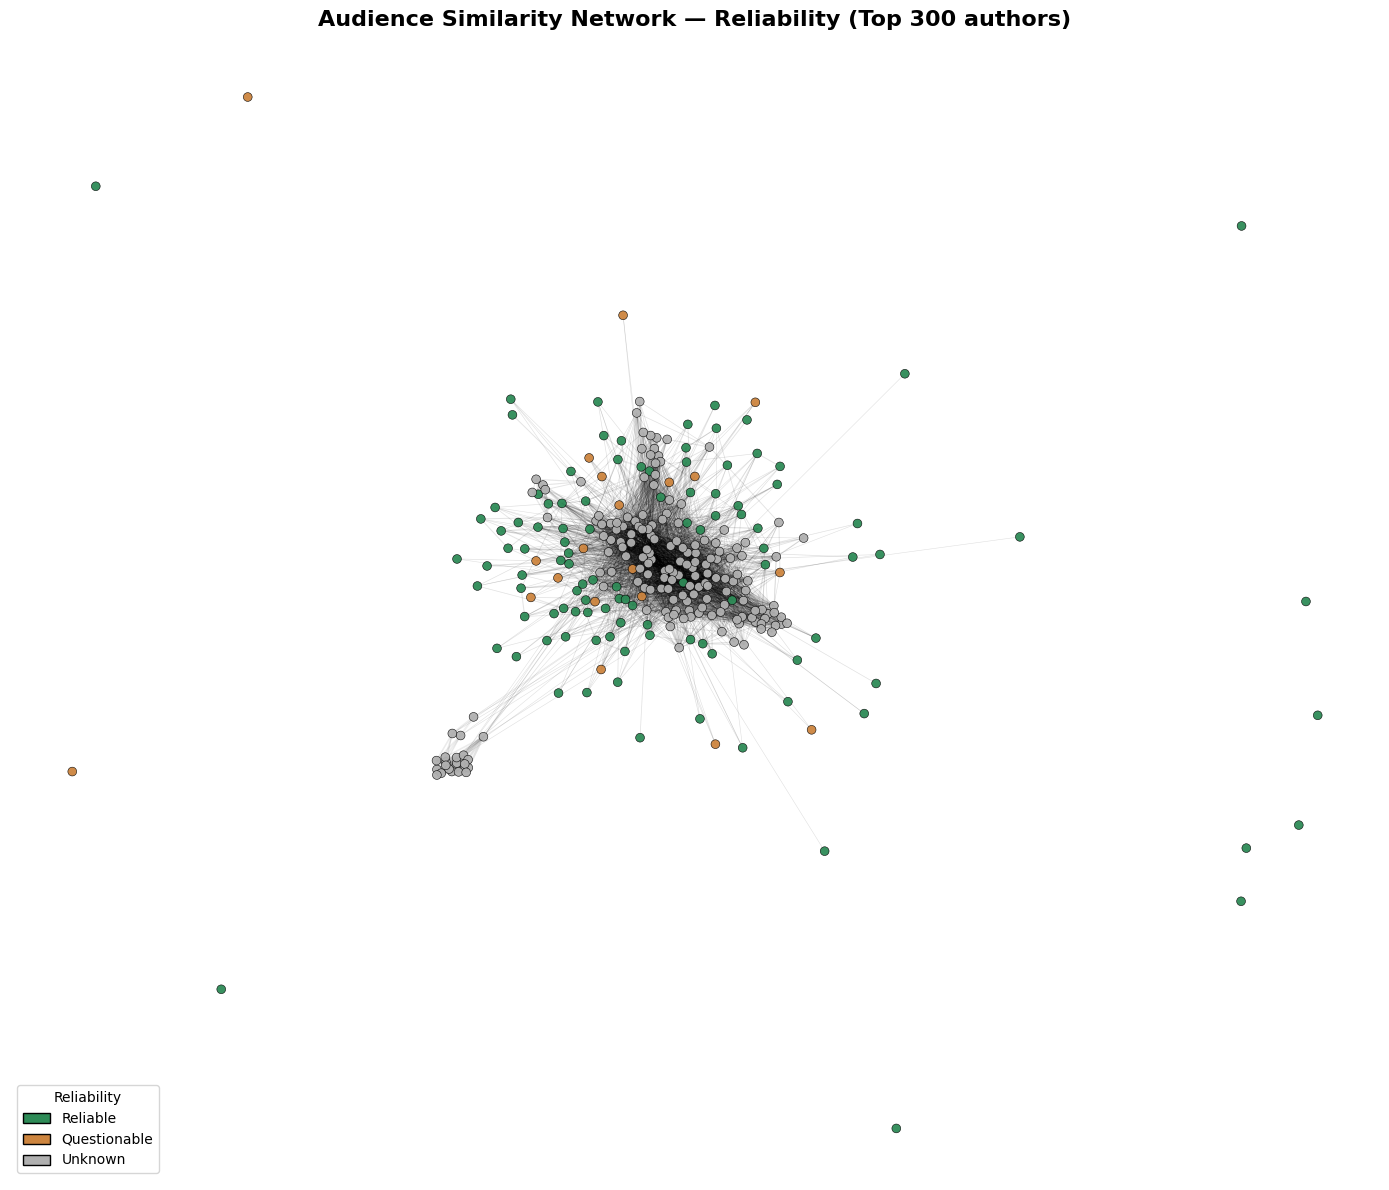

In [68]:
# Plot reliability
plt.figure(figsize=(14,12))
ax = plt.gca()
ax.set_facecolor('white')

if edges:
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u,v) for u,v,_ in edges],
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.12,
        connectionstyle='arc3,rad=0.02'
    )

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors_reliability,
    node_size=node_sizes,
    edgecolors='black',
    linewidths=0.4,
    alpha=0.95
)

plt.title("Audience Similarity Network — Reliability (Top 300 authors)",
          fontsize=16, weight='bold', pad=14)
plt.axis('off')

legend_handles_rel = [
    Patch(facecolor=color, edgecolor='black', label=label.capitalize())
    for label, color in reliability_colors.items()
]
plt.legend(handles=legend_handles_rel, title='Reliability', loc='lower left')

plt.tight_layout()
plt.savefig(OUT_PLOT_REL, dpi=300, bbox_inches='tight', facecolor='white')
safe_print(f"Saved reliability plot to {OUT_PLOT_REL}")


Saved leaning plot to network_leaning_top300.png


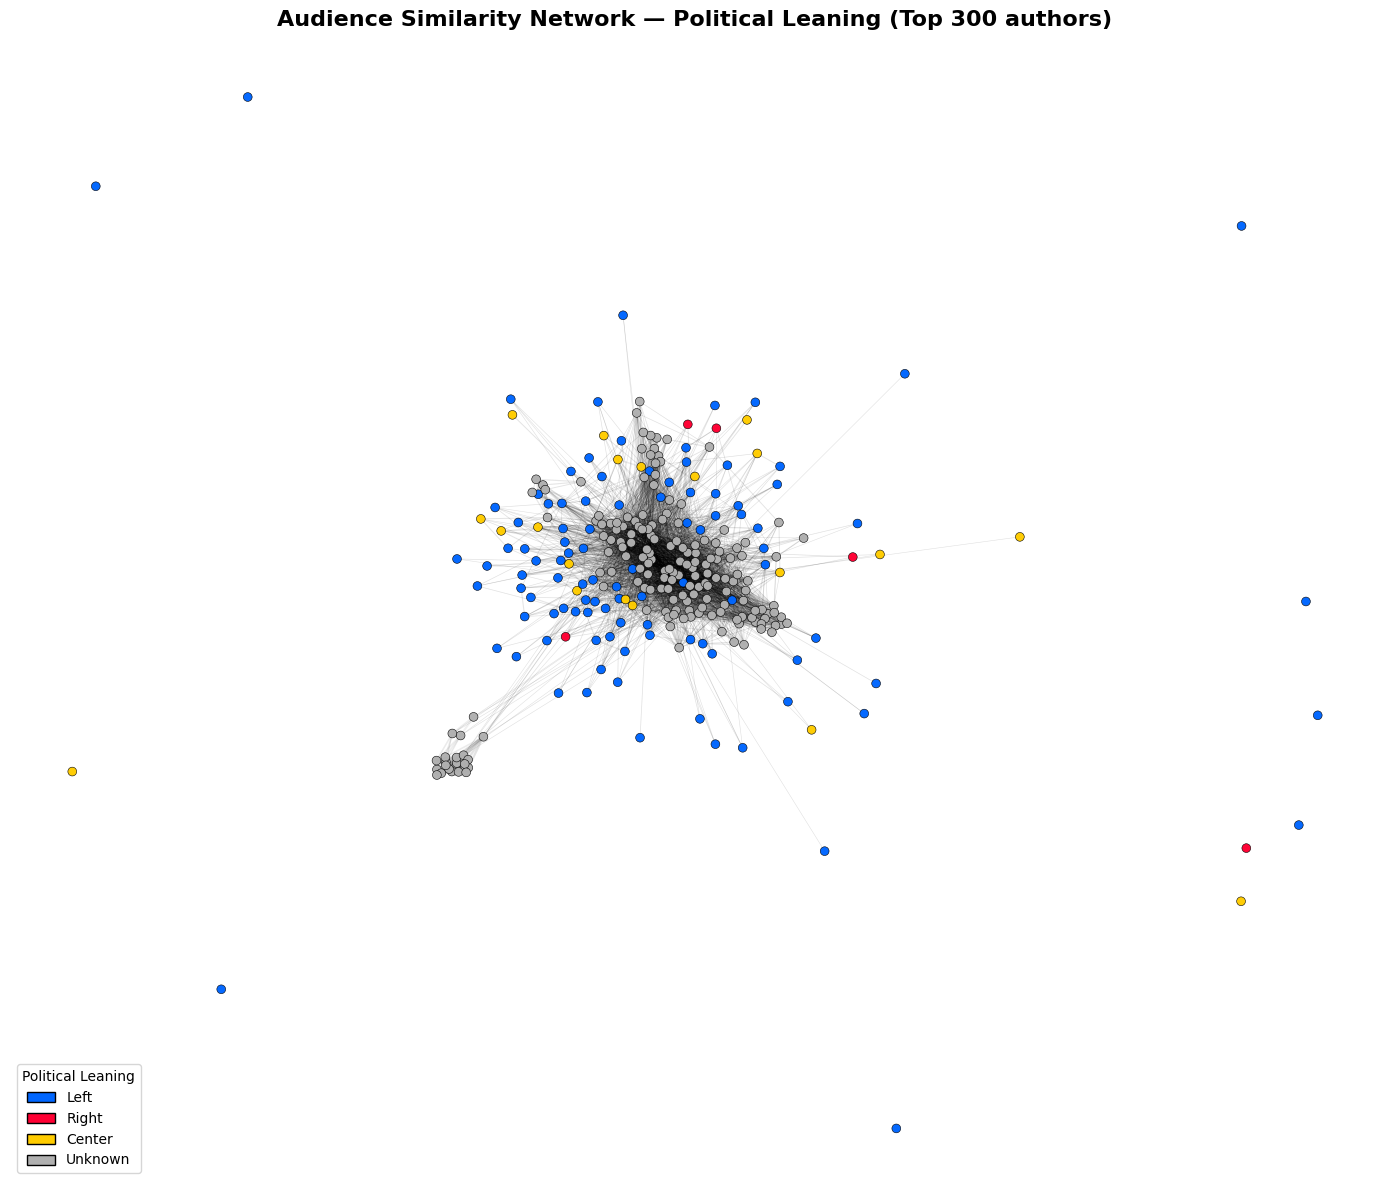

In [69]:
# Plot political leaning
plt.figure(figsize=(14,12))
ax = plt.gca()
ax.set_facecolor('white')

if edges:
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u,v) for u,v,_ in edges],
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.12,
        connectionstyle='arc3,rad=0.02'
    )

# FULL NODE COLOR by leaning (new fix)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors_leaning,
    node_size=node_sizes,
    edgecolors='black',
    linewidths=0.4,
    alpha=0.98
)

plt.title("Audience Similarity Network — Political Leaning (Top 300 authors)",
          fontsize=16, weight='bold', pad=14)
plt.axis('off')

legend_handles_lean = [
    Patch(facecolor=color, edgecolor='black', label=label.capitalize())
    for label, color in leaning_colors.items()
]
plt.legend(handles=legend_handles_lean, title='Political Leaning', loc='lower left')

plt.tight_layout()
plt.savefig(OUT_PLOT_LEAN, dpi=300, bbox_inches='tight', facecolor='white')
safe_print(f"Saved leaning plot to {OUT_PLOT_LEAN}")


In [70]:
!pip install transformers sentencepiece --quiet


In [71]:
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Load full dataset and top 300 authors
authors_df = pd.read_csv('updated_dataset.csv')  # all posts
top300_df = pd.read_csv('rank_top300_full.csv')  # top 300 authors

# Filter posts for top 300 authors
top_posts = authors_df[authors_df['author_did'].isin(top300_df['author_did'])].copy()

# Ensure datetime column exists
top_posts['created_at'] = pd.to_datetime(top_posts['created_at'], errors='coerce')

In [72]:
# Load LLM model
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
classifier = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

def create_prompt(text):
    return f"Classify the following social media post into one of these mental health categories: [anxiety, depression, stress, none].\n\nPost: \"{text}\""

# Classify all posts
results = []
for idx, row in top_posts.iterrows():
    text = str(row['text'])
    output = classifier(create_prompt(text), max_length=50)[0]['generated_text']
    results.append({'author_did': row['author_did'], 'predicted_label': output.strip()})

classified_posts = pd.DataFrame(results)

# Aggregate per author: take the **median/majority label**
def get_majority_label(labels):
    return Counter(labels).most_common(1)[0][0]

author_labels = classified_posts.groupby('author_did')['predicted_label'].apply(get_majority_label).to_dict()

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_clas

In [73]:
classified_posts

,author_did,predicted_label
0,did:plc:q7wmkrvcto52ydwb4uwqzbju,none
1,did:plc:mbsab43g7tpt5yxcowqirq2m,anxiety
2,did:plc:nphj4mp22ccn5czmjwzegtva,depression
3,did:plc:4xpckqkivrksxxyqfqb2febi,depression
4,did:plc:x24upqvi3sjxq3b6xzplf2l7,depression
...,...,...
1486,did:plc:hsd7lpzfiedzjvymcz72gpl3,none
1487,did:plc:hsd7lpzfiedzjvymcz72gpl3,none
1488,did:plc:fw3hbgfowsdmx3mp4qmxehyj,none
1489,did:plc:hmt3ygqimirlbeflljfdrxcr,none


In [74]:
# Map majority labels back to network
nx.set_node_attributes(G, author_labels, 'predicted_label')

# Assign 'none' to any node missing a label
for n in G.nodes:
    if 'predicted_label' not in G.nodes[n]:
        G.nodes[n]['predicted_label'] = 'none'


In [75]:
# Check how many posts per author were classified
posts_per_author = classified_posts.groupby('author_did').size()
print(posts_per_author.head(10))

# Check the aggregated majority labels
print(list(author_labels.items())[:10])

# Counts of authors by mental health category
mh_counts = Counter([G.nodes[n]['predicted_label'] for n in G.nodes])
print("Authors per mental health category:", mh_counts)




author_did
did:plc:223cpcieytdlbmzovhs2ypg2      1
did:plc:23rykfqtezcnbq4k4jzvpkg3    112
did:plc:263ixbri4holavs2wnyjfngc      1
did:plc:26sfxnej5emm2tkasibku62z      1
did:plc:27ayaw2igvlqshe3fvc7kwhd      1
did:plc:2a6467lkgeow52scdgvrlhej      1
did:plc:2bvxz7qsbzi5d6ztgovci5um      2
did:plc:2oniqe36yqfpa3m4oxpcooda      2
did:plc:2pondrlrs5xlg5astgfpm6i5      2
did:plc:2tiz6smelz6njio33k7t4bhf      2
dtype: int64
[('did:plc:223cpcieytdlbmzovhs2ypg2', 'anxiety'), ('did:plc:23rykfqtezcnbq4k4jzvpkg3', 'none'), ('did:plc:263ixbri4holavs2wnyjfngc', 'stress'), ('did:plc:26sfxnej5emm2tkasibku62z', 'none'), ('did:plc:27ayaw2igvlqshe3fvc7kwhd', 'stress'), ('did:plc:2a6467lkgeow52scdgvrlhej', 'stress'), ('did:plc:2bvxz7qsbzi5d6ztgovci5um', 'stress'), ('did:plc:2oniqe36yqfpa3m4oxpcooda', 'anxiety'), ('did:plc:2pondrlrs5xlg5astgfpm6i5', 'none'), ('did:plc:2tiz6smelz6njio33k7t4bhf', 'none')]
Authors per mental health category: Counter({'none': 198, 'stress': 51, 'anxiety': 42, 'depression': 

In [76]:
# Map majority labels back to network
import networkx as nx

nx.set_node_attributes(G, author_labels, 'predicted_label')

# Default label for any missing node
for n in G.nodes:
    if 'predicted_label' not in G.nodes[n]:
        G.nodes[n]['predicted_label'] = 'none'

# Mental health node colors
mh_colors = {
    'anxiety': '#FF6B6B',    # Soft Red
    'depression': '#6B5BFF', # Vibrant Blue-Purple
    'stress': '#FFD93D',     # Bright Yellow
    'none': '#A0A0A0'        # Light Gray
}

node_colors_mh = [mh_colors.get(G.nodes[n]['predicted_label'], '#A0A0A0') for n in G.nodes]


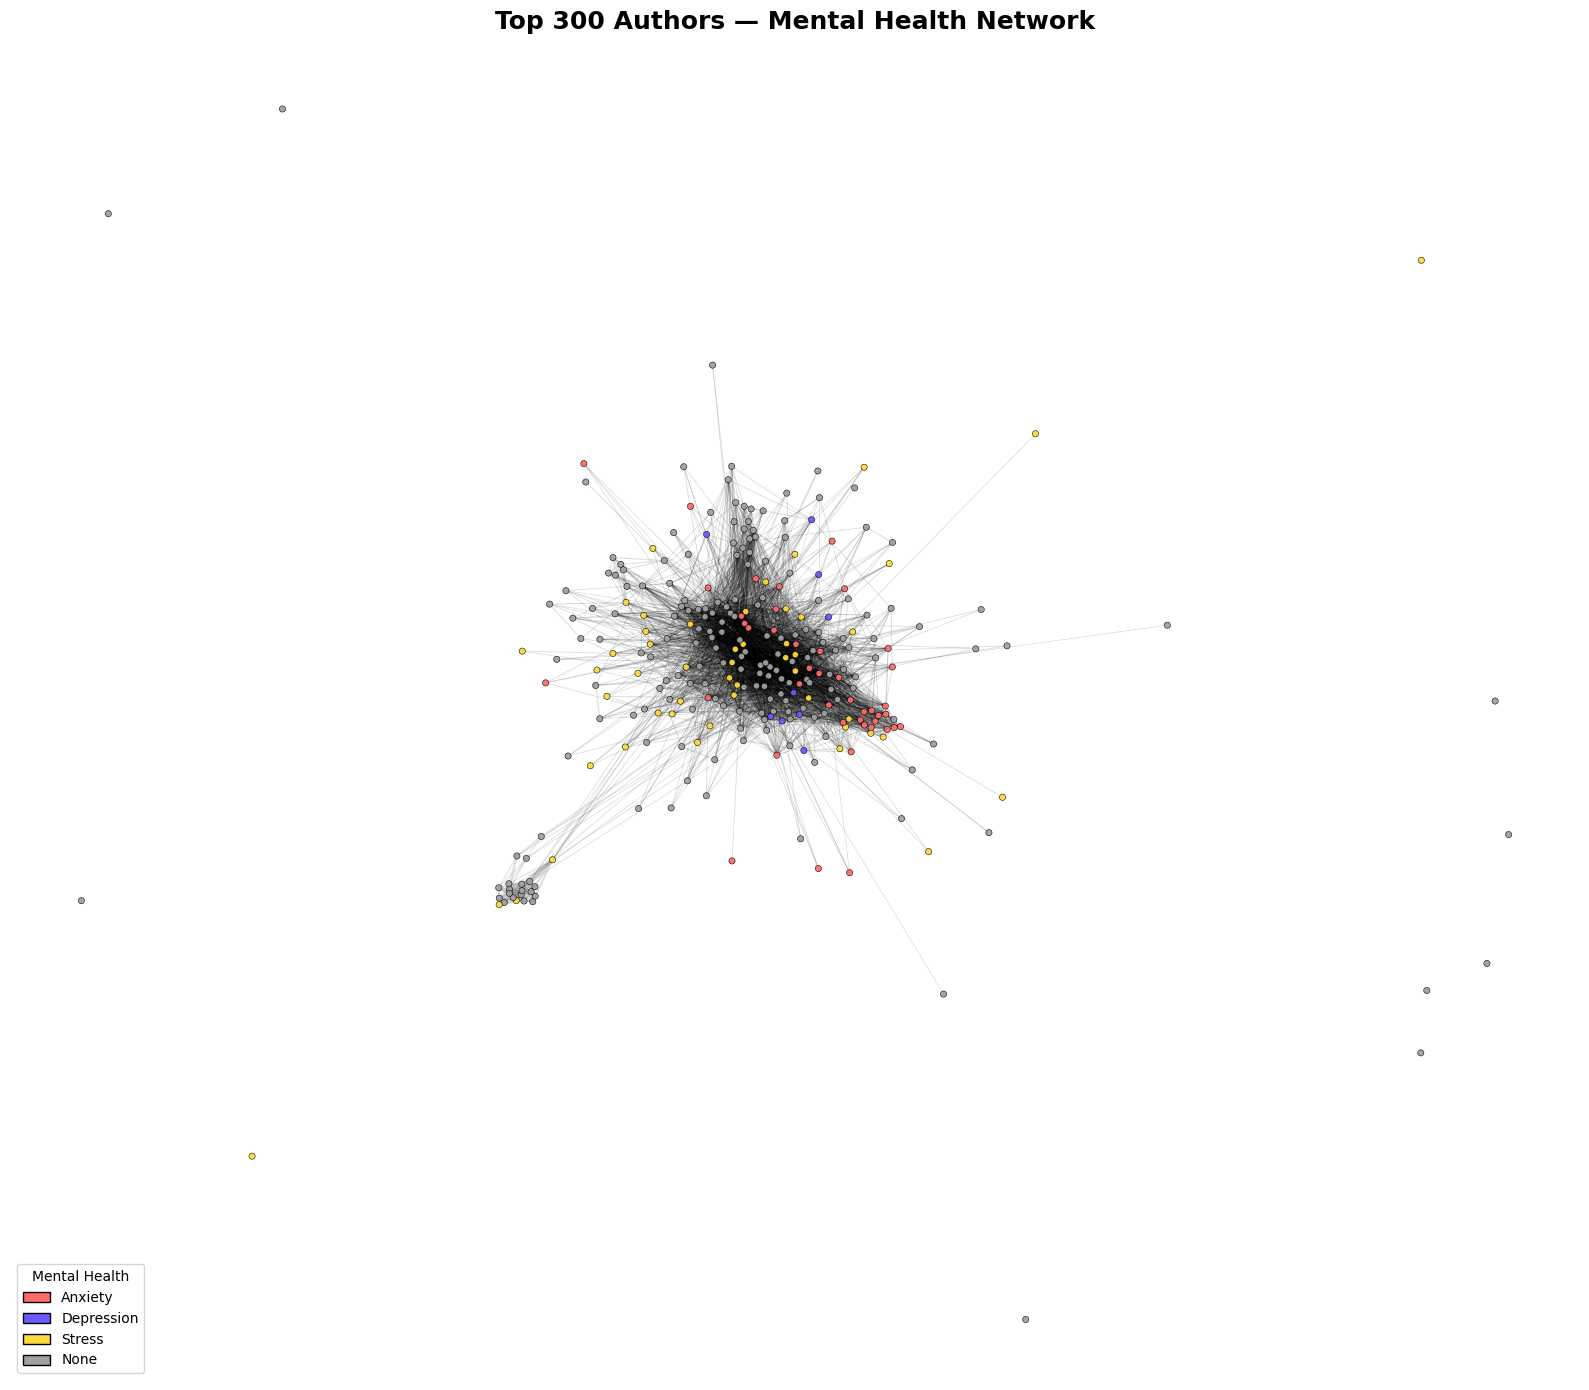

In [77]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use previously computed positions if available (pos)
plt.figure(figsize=(16,14))
ax = plt.gca()
ax.set_facecolor('white')

# Draw edges
edges = G.edges(data=True)
if edges:
    weights = [d['weight'] for (_,_,d) in edges]
    wmin, wmax = min(weights), max(weights)
    norm_w = [(w - wmin)/(wmax - wmin + 1e-12) for w in weights]
    edge_colors = [plt.cm.Greys_r(v) for v in norm_w]
    edge_widths = [0.5 + 2*v for v in norm_w]
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.15, connectionstyle='arc3,rad=0.02')

# Draw nodes
node_sizes = [20]*G.number_of_nodes()  # smaller nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors_mh, node_size=node_sizes, edgecolors='black', linewidths=0.4, alpha=0.95)

# Title & legend
plt.title("Top 300 Authors — Mental Health Network", fontsize=18, weight='bold', pad=14)
plt.axis('off')

legend_handles_mh = [Patch(facecolor=color, edgecolor='black', label=label.capitalize()) for label, color in mh_colors.items()]
plt.legend(handles=legend_handles_mh, title='Mental Health', loc='lower left')

plt.tight_layout()
plt.savefig('network_mental_health_top300.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


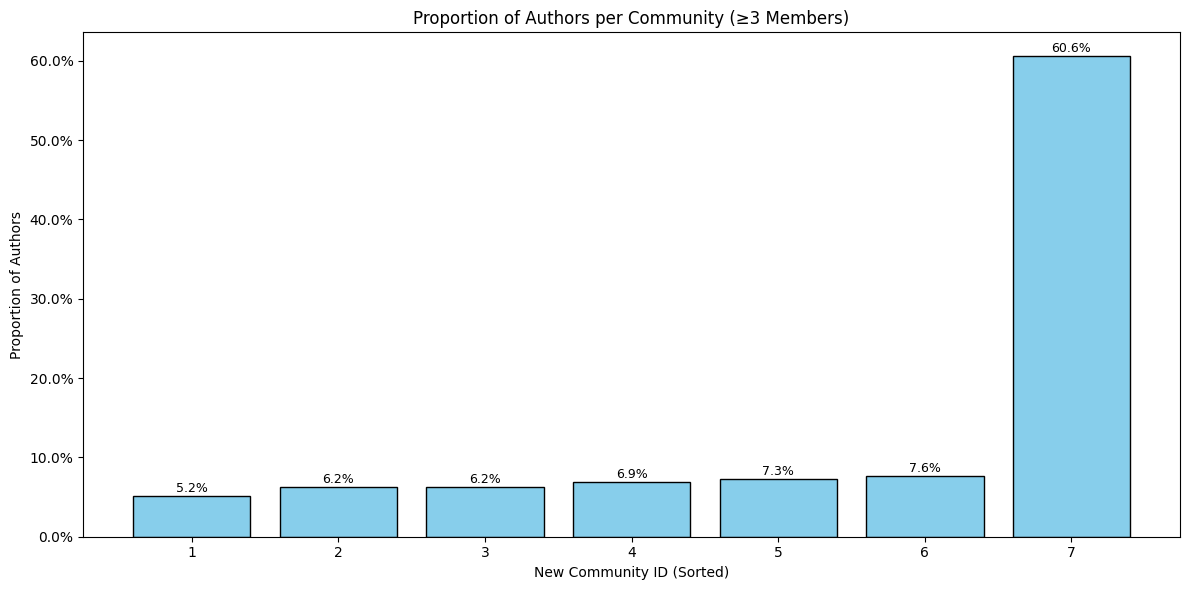

Original → New Community IDs: {0: 1, 16: 2, 4: 3, 15: 4, 3: 5, 2: 6, 1: 7}
Proportions (sorted): [0.05190311418685121, 0.06228373702422145, 0.06228373702422145, 0.06920415224913495, 0.0726643598615917, 0.07612456747404844, 0.6055363321799307]


In [78]:
# ----- COMMUNITY DETECTION -----
import community.community_louvain as community_louvain
from collections import Counter

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')

# Count authors per community
community_counts = Counter(partition.values())

# ----- FILTER communities with count < 3 -----
filtered_counts = {c: cnt for c, cnt in community_counts.items() if cnt >= 3}

# Compute total for proportion calculation
total_authors = sum(filtered_counts.values())

# Convert counts to proportions
community_props = {c: cnt / total_authors for c, cnt in filtered_counts.items()}

# ----- SORT communities by proportion (ascending) -----
sorted_items = sorted(community_props.items(), key=lambda x: x[1])

# Reset labels: 1, 2, 3... based on sorted order
reset_labels = list(range(1, len(sorted_items) + 1))

# Extract proportions
proportions = [item[1] for item in sorted_items]

# ----- PLOT -----
plt.figure(figsize=(12, 6))
plt.bar(reset_labels, proportions, color='skyblue', edgecolor='black')

# Labels
plt.xlabel('New Community ID (Sorted)')
plt.ylabel('Proportion of Authors')
plt.title('Proportion of Authors per Community (≥3 Members)')

# Y-axis formatting
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.1f}%"))

# Add text labels
for i, prop in enumerate(proportions):
    plt.text(reset_labels[i], prop + 0.005, f"{prop*100:.1f}%", ha='center', fontsize=9)

plt.xticks(reset_labels)
plt.tight_layout()
plt.savefig('community_distribution_reset_ids.png', dpi=300)
plt.show()

# Print mapping for clarity
original_to_new = {
    sorted_items[i][0]: reset_labels[i] for i in range(len(sorted_items))
}

print("Original → New Community IDs:", original_to_new)
print("Proportions (sorted):", proportions)


In [79]:
# Community counts (no changes needed)
print("Community counts:", community_counts)

Community counts: Counter({1: 175, 2: 22, 3: 21, 15: 20, 16: 18, 4: 18, 0: 15, 17: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1})


Unique communities assigned: 18
                         author_did  community
0  did:plc:q7wmkrvcto52ydwb4uwqzbju          1
1  did:plc:mbsab43g7tpt5yxcowqirq2m          1
2  did:plc:nphj4mp22ccn5czmjwzegtva          3
3  did:plc:4xpckqkivrksxxyqfqb2febi          1
4  did:plc:x24upqvi3sjxq3b6xzplf2l7          1


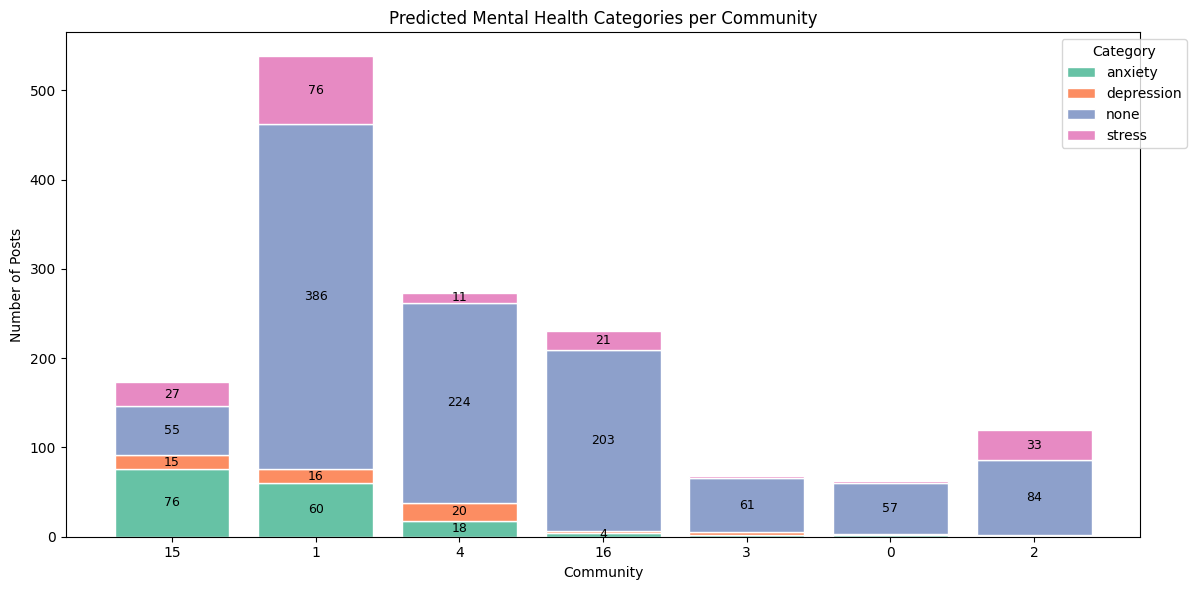

In [80]:
# 1. COPY DATAFRAME
# ------------------------------------------------------------
df = classified_posts.copy()

# ------------------------------------------------------------
# 2. ADD COMMUNITY ID (REQUIRED FIX)
# ------------------------------------------------------------
# Map each author to their community using the graph partition
df["community"] = df["author_did"].map(partition)

# Optional: map to new compact community IDs from your mapping
if "new_community_ids" in locals():
    df["community"] = df["community"].map(new_community_ids)

# ------------------------------------------------------------
# 3. CHECK IF ANY COMMUNITIES ARE MISSING
# ------------------------------------------------------------
print("Unique communities assigned:", df["community"].nunique())
print(df[["author_did", "community"]].head())

# ------------------------------------------------------------
# 4. COUNT POSTS PER COMMUNITY PER LABEL
# ------------------------------------------------------------
counts = (
    df.groupby(["community", "predicted_label"])
    .size()
    .reset_index(name="count")
)

# ------------------------------------------------------------
# 5. PIVOT INTO A MATRIX (community × label)
# ------------------------------------------------------------
pivot_df = counts.pivot(
    index="community",
    columns="predicted_label",
    values="count"
).fillna(0)

# ------------------------------------------------------------
# 6. FILTER COMMUNITIES WITH FEW POSTS (optional)
# ------------------------------------------------------------
pivot_df = pivot_df[pivot_df.sum(axis=1) >= 10]

# ------------------------------------------------------------
# 7. SORT COMMUNITIES BY TOTAL POSTS
# ------------------------------------------------------------
pivot_df = pivot_df.sort_values(
    by=pivot_df.columns.tolist(),
    ascending=False
)

# ------------------------------------------------------------
# 8. PLOT COMMUNITY-WISE CATEGORY DISTRIBUTIONS
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette("Set2", n_colors=pivot_df.shape[1])
bottoms = [0] * len(pivot_df)

# stacked bars
for i, col in enumerate(pivot_df.columns):
    ax.bar(
        pivot_df.index.astype(str),
        pivot_df[col],
        bottom=bottoms,
        label=col,
        color=colors[i],
        edgecolor="white",
    )

    # add numeric labels for segments > 3
    for x, value, bottom in zip(pivot_df.index, pivot_df[col], bottoms):
        if value > 3:
            ax.text(
                str(x),
                bottom + value / 2,
                str(int(value)),
                ha="center",
                va="center",
                fontsize=9,
            )

    # update stack height
    bottoms = [a + b for a, b in zip(bottoms, pivot_df[col])]

ax.set_xlabel("Community")
ax.set_ylabel("Number of Posts")
ax.set_title("Predicted Mental Health Categories per Community")
ax.legend(title="Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
# Save the figure
fig.savefig("community_distribution_top300.png", dpi=300, bbox_inches='tight')

plt.show()

**SECTION 1 — CLASS PREVALENCE QUANTIFICATION (CC METHOD)

In [81]:
# Extract predicted labels
labels = df["predicted_label"].values
classes = sorted(df["predicted_label"].unique())

# CC (Classify & Count)
class_counts = pd.Series(labels).value_counts(normalize=True).reindex(classes).fillna(0)

cc_quant = pd.DataFrame({
    "class": classes,
    "CC_prevalence": class_counts.values
})

cc_quant

,class,CC_prevalence
0,anxiety,0.109323
1,depression,0.039571
2,none,0.734406
3,stress,0.116700


**SECTION 2 — COMMUNITY-LEVEL QUANTIFICATION (MASS FUNCTIONS)**

In [82]:
# Count posts per (community, label)
community_label_counts = (
    df.groupby(["community", "predicted_label"])
      .size()
      .reset_index(name="count")
)

# Normalize counts within each community
community_label_counts["proportion"] = (
    community_label_counts["count"] /
    community_label_counts.groupby("community")["count"].transform("sum")
)

# Pivot cleanly
community_quant_pivot = community_label_counts.pivot(
    index="community",
    columns="predicted_label",
    values="proportion"
).fillna(0)

community_quant_pivot


predicted_label,anxiety,depression,none,stress
community,,,,
0,0.032258,0.016129,0.919355,0.032258
1,0.111524,0.029740,0.717472,0.141264
2,0.008403,0.008403,0.705882,0.277311
3,0.029412,0.044118,0.897059,0.029412
4,0.065934,0.073260,0.820513,0.040293
5,0.000000,0.000000,1.000000,0.000000
6,0.000000,0.000000,1.000000,0.000000
7,0.000000,0.000000,1.000000,0.000000
8,0.000000,0.000000,0.000000,1.000000


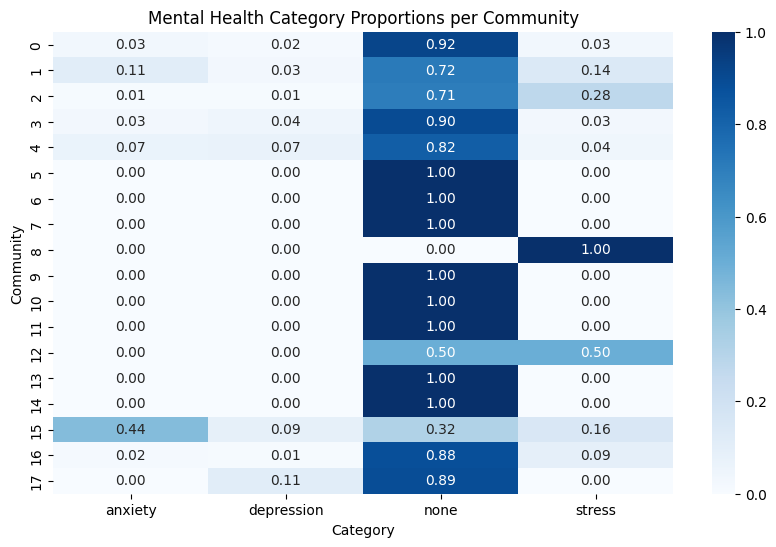

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(community_quant_pivot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Mental Health Category Proportions per Community")
plt.ylabel("Community")
plt.xlabel("Category")
plt.show()


**SECTION 3 — NETWORK QUANTIFICATION (STRUCTURAL)**

In [84]:
import networkx as nx

# --- SAFETY CHECK ---
if "G" not in globals():
    raise ValueError("Graph object G not found. Run the cell where the Final Graph is created.")

print("Graph loaded:", G)

network_metrics = {
    "num_nodes": G.number_of_nodes(),
    "num_edges": G.number_of_edges(),
    "density": nx.density(G),
    "connected_components": nx.number_connected_components(G),
    "avg_clustering_coefficient": nx.average_clustering(G),
}

# Diameter only works if graph is connected
try:
    network_metrics["diameter"] = nx.diameter(G)
except:
    network_metrics["diameter"] = "N/A (graph is not connected)"

network_metrics


Graph loaded: Graph with 300 nodes and 5300 edges


{'num_nodes': 300,
 'num_edges': 5300,
 'density': 0.11817168338907469,
 'connected_components': 12,
 'avg_clustering_coefficient': 0.6715950517110777,
 'diameter': 'N/A (graph is not connected)'}

### **SECTION 4 — NETWORK CENTRALITY QUANTIFICATION**

In [85]:
centrality = {
    "degree": nx.degree_centrality(G),
    "betweenness": nx.betweenness_centrality(G, normalized=True),
    "closeness": nx.closeness_centrality(G),
}

# Convert to dataframe sorted by degree
centrality_df = pd.DataFrame({
    "node": list(centrality["degree"].keys()),
    "degree": list(centrality["degree"].values()),
    "betweenness": list(centrality["betweenness"].values()),
    "closeness": list(centrality["closeness"].values())
}).sort_values("degree", ascending=False)

centrality_df.head(10)


,node,degree,betweenness,closeness
142,did:plc:27ayaw2igvlqshe3fvc7kwhd,0.625418,0.080570,0.684950
167,did:plc:jc4e3l6swmj7jmsocmrtdbx5,0.618729,0.090077,0.709475
151,did:plc:vsn7qxqg4kh436lkke2gbdnl,0.608696,0.100718,0.702290
148,did:plc:uo2fna47c4v6zcnklxfhcvjb,0.561873,0.053797,0.652717
129,did:plc:x4qyokjtdzgl7gmqhsw4ajqj,0.478261,0.029412,0.616455
208,did:plc:6oblddgkppfvk2ly7kxlaqob,0.461538,0.045250,0.630465
279,did:plc:77hgvuxcsdbgg5udgfndef5r,0.438127,0.043939,0.621984
160,did:plc:rlr4e4zioxivpndzr4mqw4r2,0.424749,0.019375,0.595289
168,did:plc:iy5bwfls7baqtznyuymkub2b,0.411371,0.024315,0.587722
132,did:plc:mojhr33bx3rw4dxxpehd32qz,0.411371,0.016519,0.588970
